In [1]:
# need to import cfplot before cf due to issues with matplotlib and esmpy
import cfplot as cfp
import cf
import numpy as np

In [2]:
# change to your suite-id to pick up the required file
runid='du516'

In [3]:
# read-in raw emissions data
emiss=cf.read('/home/vagrant/Tutorials/UMvn13.9/data/Task05.1/Emissions_of_CO.nc')

In [4]:
# create bounds for regridding
# longitude
bounds = emiss[0].coord('X').create_bounds()
emiss[0].coord('X').set_bounds(bounds)
# latitude
bounds = emiss[0].coord('Y').create_bounds()
emiss[0].coord('Y').set_bounds(bounds)

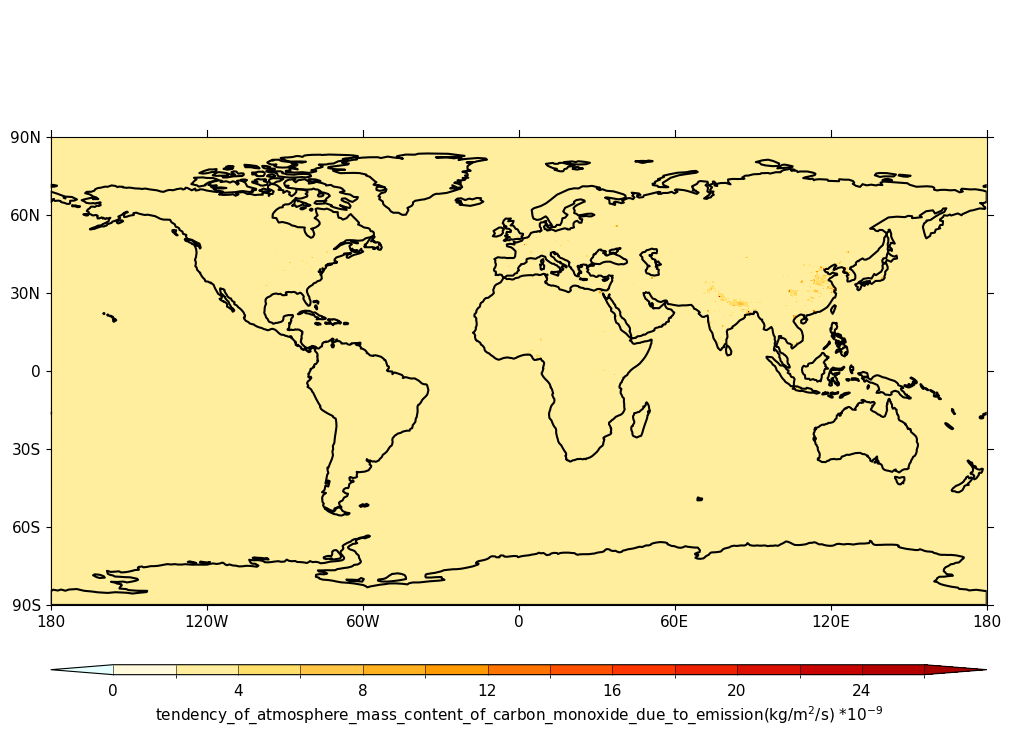

In [5]:
# plot the current emissions field
cfp.con(emiss[0][0,:,:],blockfill_fast=True,lines=False)

In [6]:
# read-in a UKCA field from our model output - take O3 as basic shape
# This should already have bounds created when read-in
datafile='/home/vagrant/cylc-run/u-'+runid+'/runN/work/1/atmos/atmosa.pa19810901_00'
indata=cf.read(datafile, select='stash_code=34010')

In [7]:
# set missing_value and _FillValue
fillval=1e+20
emiss[0].missing_value=np.float32(fillval)
emiss[0]._FillValue=np.float32(fillval)

In [8]:
# regrid the file to the shape provided by the ozone field, using a conservative mass conserving approach
emiss_regrid=emiss[0].regrids(indata[0], 'conservative')

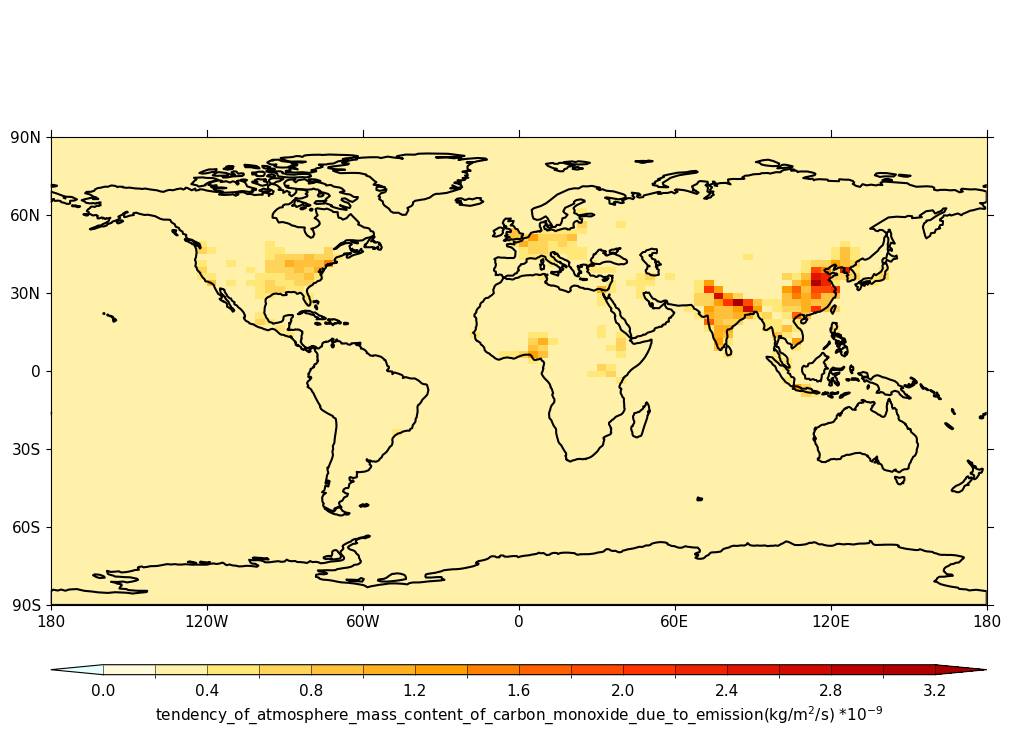

In [9]:
# plot the field after regridding
cfp.con(emiss_regrid[0,:,:],blockfill_fast=True,lines=False)

In [10]:
# rename and add properties to the variable
emiss_regrid.nc_set_variable('emissions_CO')
emiss_regrid.set_property('long_name','CO surf emissions')
emiss_regrid.set_property('tracer_name','CO')
emiss_regrid.set_property('vertical_scaling','surface')
emiss_regrid.set_property('units','kg m-2 s-1')

In [11]:
# set required attributes for the time dimension, including re-dating it to 0000
emiss_regrid.coordinate('T').nc_set_variable('time')
emiss_regrid.coordinate('T').set_property('standard_name','time')
# as there is no calendar currently, force a calendar to exist
emiss_regrid.coordinate('T').override_calendar('360_day', inplace=True)
emiss_regrid.coordinate('T').set_property('time_origin','01-JAN-1970:00:00:00')
emiss_regrid.coordinate('T').set_property('calendar_flexible','1')
emiss_regrid.coordinate('T').set_property('units','hours since 1970-01-01')
# re-date field so it is now starting at 0000-01-16:00.00.00 etc.
emiss_regrid.coordinate('T').set_data(np.array([-17020440, -17019720, -17019000, -17018280,
                                                -17017560, -17016840, -17016120, -17015400, 
                                                -17014680, -17013960, -17013240, -17012520], dtype=np.float32)) 

In [12]:
# need to insert a Z axis of size 1
c = cf.DomainAxis()
c.set_size(1)
c.nc_set_dimension('model_level_number')
emiss_regrid.set_construct(c, key='domainaxis3', copy=False)
c = cf.DimensionCoordinate()
c.set_properties({'axis': 'Z', 'units': '1', 'standard_name': 'model_level_number', 'positive': 'up'})
c.nc_set_variable('model_level_number')
data = np.array([0])
c.set_data(data)
emiss_regrid.set_construct(c, axes=('domainaxis3',), key='dimensioncoordinate3', copy=False)
emiss_regrid.insert_dimension('Z', 1, inplace=True)

In [13]:
# set the necessary global attributes
# 5-day update frequency
emiss_regrid.nc_set_global_attribute('update_freq_in_hours','120')
# periodic file
emiss_regrid.nc_set_global_attribute('update_type','2')

In [14]:
# save the file in NetCDF format
cf.write(emiss_regrid, '/home/vagrant/cf_ukca_emiss_CO.nc', fmt='NETCDF4')